In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [2]:
# global variables

look_back = 21
lead_time = 150
filename = '../../../data/Arctic_domain_mean_1979_2018 - Curated.csv'
pcmciplus_features = ['LW_down', 'snowfall', 'sst', 'sosaline', 'surface_pressure', 'sea_ice_extent']

In [3]:
# from google.colab import files
# import io

# uploaded = files.upload()
# df = pd.read_csv(io.BytesIO(uploaded[filename]))
# df = df[7305:]
# df

# Reading the dataset
df = pd.read_csv(filename)
df = df[7305:]
df.head()

,Day,wind_10m,specific_humidity,LW_down,SW_down,rainfall,snowfall,sosaline,sst,t2m,surface_pressure,sea_ice_extent
7305,1/1/1999,4.987515,0.891843,183.786092,1.120906,0.700735,0.501109,33.316996,273.467869,250.884060,985.112721,13823248
7306,1/2/1999,5.075952,0.905535,183.851814,1.193514,0.712730,0.482221,33.316996,273.453826,250.359328,984.092282,13885522
7307,1/3/1999,4.931520,0.911672,184.426913,1.263909,0.677339,0.480718,33.316996,273.454385,250.327500,982.300080,13884279
7308,1/4/1999,4.761644,0.911301,187.528326,1.269229,0.824016,0.697950,33.316996,273.459797,249.905730,983.250565,13912624
7309,1/5/1999,4.739850,0.901353,187.326709,1.552208,0.926681,0.835868,33.316996,273.463975,250.254873,984.247389,13890148


In [18]:
df['Day'] = pd.to_datetime(df['Day'], infer_datetime_format=True)
df.set_index('Day', inplace=True)
df = df.astype(float)                 # cast df to float
df = df[pcmciplus_features]
df.tail(len(df))

,LW_down,snowfall,sst,sosaline,surface_pressure,sea_ice_extent
Day,,,,,,
1999-01-01,183.786092,0.501109,273.467869,33.316996,985.112721,13823248.0
1999-01-02,183.851814,0.482221,273.453826,33.316996,984.092282,13885522.0
1999-01-03,184.426913,0.480718,273.454385,33.316996,982.300080,13884279.0
1999-01-04,187.528326,0.697950,273.459797,33.316996,983.250565,13912624.0
1999-01-05,187.326709,0.835868,273.463975,33.316996,984.247389,13890148.0
...,...,...,...,...,...,...
2018-12-27,195.631612,0.807935,273.993458,33.437008,983.214961,12324834.0
2018-12-28,195.926366,0.906977,274.009713,33.437008,983.126983,12343956.0
2018-12-29,197.973447,1.065541,273.986577,33.437008,981.042709,12523124.0


In [19]:
def create_model_data (dataset, look_back, lead_time):
    dataX, dataY = [], []
    
    for i in range(len(dataset)-look_back-lead_time):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back + (lead_time-1)])
    return np.array(dataX), np.array(dataY)

In [20]:
target_index = df.columns.tolist().index('sea_ice_extent')

dataset = df.values.astype('float32')               # DataFrame converted to Numpy Array

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

X, y = create_model_data (dataset, look_back=look_back, lead_time=lead_time)
y = y[:,target_index]

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

<function matplotlib.pyplot.show(*args, **kw)>

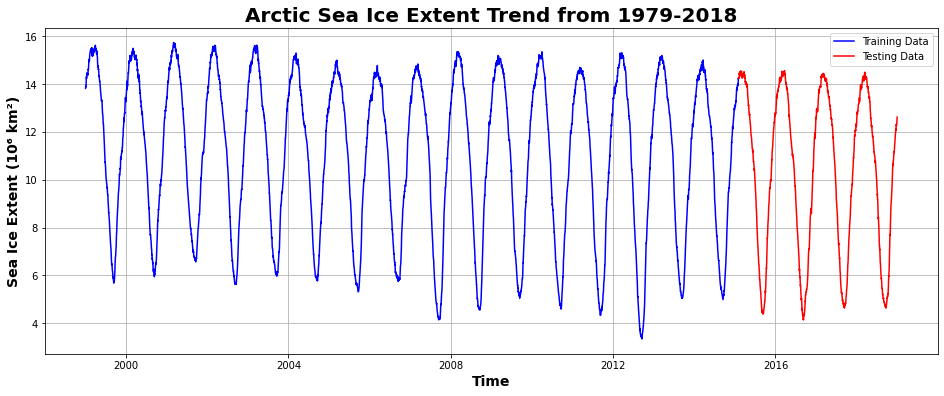

In [22]:
plt.figure(figsize = (16,6))
ax = plt.axes()
# ax.set_facecolor('#dcdcdc')

plt.title('Arctic Sea Ice Extent Trend from 1979-2018', fontsize = 20,fontweight = "bold")
plt.xlabel('Time' , fontsize = 14,fontweight = "bold")
plt.ylabel('Sea Ice Extent (10\u2076 km\u00b2)', fontsize = 14,fontweight = "bold")
plt.plot(df['sea_ice_extent'][:len(df)-len(y_test)]/10**6, 'blue', label='Training Data')
plt.plot(df['sea_ice_extent'][len(df)-len(y_test):]/10**6, 'red', label='Testing Data')
plt.legend()
plt.grid()
plt.show

In [23]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Input, LSTM, GRU, Dense

input_shape=(X.shape[1], X.shape[2])

model = Sequential()
model.add(GRU(64, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(128))
model.add(Dropout(0.2))

model.add(Dense(64 ,  activation = 'relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mse'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 21, 64)            13824     
                                                                 
 dropout_2 (Dropout)         (None, 21, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               98816     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 120,961
Trainable params: 120,961
Non-tr

In [24]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("weights.best.hdf5", monitor='val_mean_squared_error', verbose=1, save_best_only=True, mode='min')

callbacks_list = [checkpoint]
history = model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1, callbacks=callbacks_list, validation_split=0.1)

Epoch 1/100
75/81 [==========================>...] - ETA: 0s - loss: 0.0319 - mae: 0.1296 - mse: 0.0319

81/81 [==============================] - 4s 16ms/step - loss: 0.0305 - mae: 0.1265 - mse: 0.0305 - val_loss: 0.0045 - val_mae: 0.0548 - val_mse: 0.0045
Epoch 2/100
79/81 [============================>.] - ETA: 0s - loss: 0.0087 - mae: 0.0739 - mse: 0.0087

81/81 [==============================] - 1s 8ms/step - loss: 0.0087 - mae: 0.0738 - mse: 0.0087 - val_loss: 0.0042 - val_mae: 0.0548 - val_mse: 0.0042
Epoch 3/100
80/81 [============================>.] - ETA: 0s - loss: 0.0063 - mae: 0.0627 - mse: 0.0063

81/81 [==============================] - 1s 8ms/step - loss: 0.0063 - mae: 0.0627 - mse: 0.0063 - val_loss: 0.0053 - val_mae: 0.0631 - val_mse: 0.0053
Epoch 4/100
77/81 [===========================>..] - ETA: 0s - loss: 0.0060 - mae: 0.0614 - mse: 0.0060

81/81 [==============================] - 1s 8ms/step - loss: 0.0060 - mae: 0.0614 - mse: 0.0060 - val_loss: 0.0041 - val_mae: 0.0461 - val_mse: 0.0041
Epoch 5/100
76/81 [===========================>..] - ETA: 0s - loss: 0.0053 - mae: 0.0573 - mse: 0.0053

81/81 [==============================] - 1s 8ms/step - loss: 0.0052 - mae: 0.0570 - mse: 0.0052 - val_loss: 0.0022 - val_mae: 0.0349 - val_mse: 0.0022
Epoch 6/100
79/81 [============================>.] - ETA: 0s - loss: 0.0046 - mae: 0.0533 - mse: 0.0046

81/81 [==============================] - 1s 8ms/step - loss: 0.0046 - mae: 0.0533 - mse: 0.0046 - val_loss: 0.0037 - val_mae: 0.0515 - val_mse: 0.0037
Epoch 7/100
77/81 [===========================>..] - ETA: 0s - loss: 0.0045 - mae: 0.0521 - mse: 0.0045

81/81 [==============================] - 1s 8ms/step - loss: 0.0045 - mae: 0.0520 - mse: 0.0045 - val_loss: 0.0044 - val_mae: 0.0455 - val_mse: 0.0044
Epoch 8/100
79/81 [============================>.] - ETA: 0s - loss: 0.0042 - mae: 0.0501 - mse: 0.0042

81/81 [==============================] - 1s 9ms/step - loss: 0.0042 - mae: 0.0501 - mse: 0.0042 - val_loss: 0.0029 - val_mae: 0.0381 - val_mse: 0.0029
Epoch 9/100
74/81 [==========================>...] - ETA: 0s - loss: 0.0041 - mae: 0.0495 - mse: 0.0041

81/81 [==============================] - 1s 8ms/step - loss: 0.0040 - mae: 0.0494 - mse: 0.0040 - val_loss: 0.0035 - val_mae: 0.0449 - val_mse: 0.0035
Epoch 10/100
74/81 [==========================>...] - ETA: 0s - loss: 0.0041 - mae: 0.0499 - mse: 0.0041

81/81 [==============================] - 1s 8ms/step - loss: 0.0042 - mae: 0.0501 - mse: 0.0042 - val_loss: 0.0021 - val_mae: 0.0371 - val_mse: 0.0021
Epoch 11/100
77/81 [===========================>..] - ETA: 0s - loss: 0.0037 - mae: 0.0474 - mse: 0.0037

81/81 [==============================] - 1s 8ms/step - loss: 0.0038 - mae: 0.0475 - mse: 0.0038 - val_loss: 0.0045 - val_mae: 0.0441 - val_mse: 0.0045
Epoch 12/100
81/81 [==============================] - ETA: 0s - loss: 0.0038 - mae: 0.0475 - mse: 0.0038

81/81 [==============================] - 1s 10ms/step - loss: 0.0038 - mae: 0.0475 - mse: 0.0038 - val_loss: 0.0028 - val_mae: 0.0409 - val_mse: 0.0028
Epoch 13/100
79/81 [============================>.] - ETA: 0s - loss: 0.0036 - mae: 0.0462 - mse: 0.0036

81/81 [==============================] - 1s 11ms/step - loss: 0.0036 - mae: 0.0462 - mse: 0.0036 - val_loss: 0.0030 - val_mae: 0.0418 - val_mse: 0.0030
Epoch 14/100
78/81 [===========================>..] - ETA: 0s - loss: 0.0038 - mae: 0.0475 - mse: 0.0038

81/81 [==============================] - 1s 11ms/step - loss: 0.0038 - mae: 0.0475 - mse: 0.0038 - val_loss: 0.0027 - val_mae: 0.0367 - val_mse: 0.0027
Epoch 15/100
81/81 [==============================] - ETA: 0s - loss: 0.0034 - mae: 0.0452 - mse: 0.0034

81/81 [==============================] - 1s 8ms/step - loss: 0.0034 - mae: 0.0452 - mse: 0.0034 - val_loss: 0.0024 - val_mae: 0.0390 - val_mse: 0.0024
Epoch 16/100
79/81 [============================>.] - ETA: 0s - loss: 0.0036 - mae: 0.0459 - mse: 0.0036

81/81 [==============================] - 1s 8ms/step - loss: 0.0036 - mae: 0.0461 - mse: 0.0036 - val_loss: 0.0035 - val_mae: 0.0436 - val_mse: 0.0035
Epoch 17/100
74/81 [==========================>...] - ETA: 0s - loss: 0.0037 - mae: 0.0467 - mse: 0.0037

81/81 [==============================] - 1s 8ms/step - loss: 0.0037 - mae: 0.0466 - mse: 0.0037 - val_loss: 0.0026 - val_mae: 0.0424 - val_mse: 0.0026
Epoch 18/100
78/81 [===========================>..] - ETA: 0s - loss: 0.0034 - mae: 0.0448 - mse: 0.0034

81/81 [==============================] - 1s 8ms/step - loss: 0.0034 - mae: 0.0447 - mse: 0.0034 - val_loss: 0.0024 - val_mae: 0.0346 - val_mse: 0.0024
Epoch 19/100
75/81 [==========================>...] - ETA: 0s - loss: 0.0033 - mae: 0.0442 - mse: 0.0033

81/81 [==============================] - 1s 8ms/step - loss: 0.0033 - mae: 0.0442 - mse: 0.0033 - val_loss: 0.0031 - val_mae: 0.0397 - val_mse: 0.0031
Epoch 20/100
75/81 [==========================>...] - ETA: 0s - loss: 0.0036 - mae: 0.0455 - mse: 0.0036

81/81 [==============================] - 1s 8ms/step - loss: 0.0036 - mae: 0.0459 - mse: 0.0036 - val_loss: 0.0026 - val_mae: 0.0356 - val_mse: 0.0026
Epoch 21/100
76/81 [===========================>..] - ETA: 0s - loss: 0.0034 - mae: 0.0443 - mse: 0.0034

81/81 [==============================] - 1s 8ms/step - loss: 0.0034 - mae: 0.0444 - mse: 0.0034 - val_loss: 0.0018 - val_mae: 0.0324 - val_mse: 0.0018
Epoch 22/100
79/81 [============================>.] - ETA: 0s - loss: 0.0033 - mae: 0.0443 - mse: 0.0033

81/81 [==============================] - 1s 8ms/step - loss: 0.0033 - mae: 0.0443 - mse: 0.0033 - val_loss: 0.0029 - val_mae: 0.0396 - val_mse: 0.0029
Epoch 23/100
78/81 [===========================>..] - ETA: 0s - loss: 0.0033 - mae: 0.0436 - mse: 0.0033

81/81 [==============================] - 1s 8ms/step - loss: 0.0033 - mae: 0.0436 - mse: 0.0033 - val_loss: 0.0026 - val_mae: 0.0369 - val_mse: 0.0026
Epoch 24/100
77/81 [===========================>..] - ETA: 0s - loss: 0.0030 - mae: 0.0416 - mse: 0.0030

81/81 [==============================] - 1s 8ms/step - loss: 0.0030 - mae: 0.0417 - mse: 0.0030 - val_loss: 0.0034 - val_mae: 0.0434 - val_mse: 0.0034
Epoch 25/100
76/81 [===========================>..] - ETA: 0s - loss: 0.0031 - mae: 0.0425 - mse: 0.0031

81/81 [==============================] - 1s 8ms/step - loss: 0.0031 - mae: 0.0425 - mse: 0.0031 - val_loss: 0.0028 - val_mae: 0.0381 - val_mse: 0.0028
Epoch 26/100
78/81 [===========================>..] - ETA: 0s - loss: 0.0031 - mae: 0.0429 - mse: 0.0031

81/81 [==============================] - 1s 8ms/step - loss: 0.0031 - mae: 0.0428 - mse: 0.0031 - val_loss: 0.0034 - val_mae: 0.0396 - val_mse: 0.0034
Epoch 27/100
78/81 [===========================>..] - ETA: 0s - loss: 0.0031 - mae: 0.0425 - mse: 0.0031

81/81 [==============================] - 1s 8ms/step - loss: 0.0031 - mae: 0.0426 - mse: 0.0031 - val_loss: 0.0052 - val_mae: 0.0504 - val_mse: 0.0052
Epoch 28/100
76/81 [===========================>..] - ETA: 0s - loss: 0.0033 - mae: 0.0435 - mse: 0.0033

81/81 [==============================] - 1s 8ms/step - loss: 0.0032 - mae: 0.0434 - mse: 0.0032 - val_loss: 0.0035 - val_mae: 0.0416 - val_mse: 0.0035
Epoch 29/100
79/81 [============================>.] - ETA: 0s - loss: 0.0030 - mae: 0.0422 - mse: 0.0030

81/81 [==============================] - 1s 8ms/step - loss: 0.0030 - mae: 0.0421 - mse: 0.0030 - val_loss: 0.0031 - val_mae: 0.0373 - val_mse: 0.0031
Epoch 30/100
81/81 [==============================] - ETA: 0s - loss: 0.0028 - mae: 0.0402 - mse: 0.0028

81/81 [==============================] - 1s 8ms/step - loss: 0.0028 - mae: 0.0402 - mse: 0.0028 - val_loss: 0.0042 - val_mae: 0.0406 - val_mse: 0.0042
Epoch 31/100
81/81 [==============================] - ETA: 0s - loss: 0.0030 - mae: 0.0415 - mse: 0.0030

81/81 [==============================] - 1s 8ms/step - loss: 0.0030 - mae: 0.0415 - mse: 0.0030 - val_loss: 0.0038 - val_mae: 0.0418 - val_mse: 0.0038
Epoch 32/100
81/81 [==============================] - ETA: 0s - loss: 0.0027 - mae: 0.0394 - mse: 0.0027

81/81 [==============================] - 1s 8ms/step - loss: 0.0027 - mae: 0.0394 - mse: 0.0027 - val_loss: 0.0055 - val_mae: 0.0514 - val_mse: 0.0055
Epoch 33/100
77/81 [===========================>..] - ETA: 0s - loss: 0.0028 - mae: 0.0406 - mse: 0.0028

81/81 [==============================] - 1s 8ms/step - loss: 0.0029 - mae: 0.0406 - mse: 0.0029 - val_loss: 0.0042 - val_mae: 0.0414 - val_mse: 0.0042
Epoch 34/100
79/81 [============================>.] - ETA: 0s - loss: 0.0026 - mae: 0.0382 - mse: 0.0026

81/81 [==============================] - 1s 8ms/step - loss: 0.0026 - mae: 0.0383 - mse: 0.0026 - val_loss: 0.0028 - val_mae: 0.0369 - val_mse: 0.0028
Epoch 35/100
81/81 [==============================] - ETA: 0s - loss: 0.0028 - mae: 0.0401 - mse: 0.0028

81/81 [==============================] - 1s 8ms/step - loss: 0.0028 - mae: 0.0401 - mse: 0.0028 - val_loss: 0.0027 - val_mae: 0.0377 - val_mse: 0.0027
Epoch 36/100
78/81 [===========================>..] - ETA: 0s - loss: 0.0026 - mae: 0.0393 - mse: 0.0026

81/81 [==============================] - 1s 8ms/step - loss: 0.0027 - mae: 0.0394 - mse: 0.0027 - val_loss: 0.0029 - val_mae: 0.0392 - val_mse: 0.0029
Epoch 37/100
78/81 [===========================>..] - ETA: 0s - loss: 0.0026 - mae: 0.0390 - mse: 0.0026

81/81 [==============================] - 1s 8ms/step - loss: 0.0026 - mae: 0.0390 - mse: 0.0026 - val_loss: 0.0031 - val_mae: 0.0421 - val_mse: 0.0031
Epoch 38/100
81/81 [==============================] - ETA: 0s - loss: 0.0028 - mae: 0.0402 - mse: 0.0028

81/81 [==============================] - 1s 8ms/step - loss: 0.0028 - mae: 0.0402 - mse: 0.0028 - val_loss: 0.0022 - val_mae: 0.0356 - val_mse: 0.0022
Epoch 39/100
78/81 [===========================>..] - ETA: 0s - loss: 0.0025 - mae: 0.0383 - mse: 0.0025

81/81 [==============================] - 1s 8ms/step - loss: 0.0026 - mae: 0.0384 - mse: 0.0026 - val_loss: 0.0032 - val_mae: 0.0454 - val_mse: 0.0032
Epoch 40/100
79/81 [============================>.] - ETA: 0s - loss: 0.0028 - mae: 0.0406 - mse: 0.0028

81/81 [==============================] - 1s 8ms/step - loss: 0.0028 - mae: 0.0406 - mse: 0.0028 - val_loss: 0.0031 - val_mae: 0.0438 - val_mse: 0.0031
Epoch 41/100
77/81 [===========================>..] - ETA: 0s - loss: 0.0026 - mae: 0.0390 - mse: 0.0026

81/81 [==============================] - 1s 8ms/step - loss: 0.0026 - mae: 0.0390 - mse: 0.0026 - val_loss: 0.0042 - val_mae: 0.0461 - val_mse: 0.0042
Epoch 42/100
79/81 [============================>.] - ETA: 0s - loss: 0.0024 - mae: 0.0370 - mse: 0.0024

81/81 [==============================] - 1s 8ms/step - loss: 0.0024 - mae: 0.0370 - mse: 0.0024 - val_loss: 0.0032 - val_mae: 0.0415 - val_mse: 0.0032
Epoch 43/100
81/81 [==============================] - ETA: 0s - loss: 0.0024 - mae: 0.0377 - mse: 0.0024

81/81 [==============================] - 1s 10ms/step - loss: 0.0024 - mae: 0.0377 - mse: 0.0024 - val_loss: 0.0045 - val_mae: 0.0479 - val_mse: 0.0045
Epoch 44/100
77/81 [===========================>..] - ETA: 0s - loss: 0.0024 - mae: 0.0375 - mse: 0.0024

81/81 [==============================] - 1s 11ms/step - loss: 0.0024 - mae: 0.0375 - mse: 0.0024 - val_loss: 0.0047 - val_mae: 0.0492 - val_mse: 0.0047
Epoch 45/100
76/81 [===========================>..] - ETA: 0s - loss: 0.0023 - mae: 0.0367 - mse: 0.0023

81/81 [==============================] - 1s 12ms/step - loss: 0.0023 - mae: 0.0370 - mse: 0.0023 - val_loss: 0.0059 - val_mae: 0.0593 - val_mse: 0.0059
Epoch 46/100
79/81 [============================>.] - ETA: 0s - loss: 0.0024 - mae: 0.0375 - mse: 0.0024

81/81 [==============================] - 1s 8ms/step - loss: 0.0024 - mae: 0.0375 - mse: 0.0024 - val_loss: 0.0032 - val_mae: 0.0431 - val_mse: 0.0032
Epoch 47/100
81/81 [==============================] - ETA: 0s - loss: 0.0024 - mae: 0.0370 - mse: 0.0024

81/81 [==============================] - 1s 8ms/step - loss: 0.0024 - mae: 0.0370 - mse: 0.0024 - val_loss: 0.0044 - val_mae: 0.0491 - val_mse: 0.0044
Epoch 48/100
80/81 [============================>.] - ETA: 0s - loss: 0.0022 - mae: 0.0354 - mse: 0.0022

81/81 [==============================] - 1s 8ms/step - loss: 0.0022 - mae: 0.0354 - mse: 0.0022 - val_loss: 0.0035 - val_mae: 0.0470 - val_mse: 0.0035
Epoch 49/100
75/81 [==========================>...] - ETA: 0s - loss: 0.0024 - mae: 0.0372 - mse: 0.0024

81/81 [==============================] - 1s 8ms/step - loss: 0.0023 - mae: 0.0371 - mse: 0.0023 - val_loss: 0.0038 - val_mae: 0.0496 - val_mse: 0.0038
Epoch 50/100
76/81 [===========================>..] - ETA: 0s - loss: 0.0023 - mae: 0.0370 - mse: 0.0023

81/81 [==============================] - 1s 8ms/step - loss: 0.0023 - mae: 0.0371 - mse: 0.0023 - val_loss: 0.0034 - val_mae: 0.0428 - val_mse: 0.0034
Epoch 51/100
81/81 [==============================] - ETA: 0s - loss: 0.0023 - mae: 0.0371 - mse: 0.0023

81/81 [==============================] - 1s 8ms/step - loss: 0.0023 - mae: 0.0371 - mse: 0.0023 - val_loss: 0.0041 - val_mae: 0.0438 - val_mse: 0.0041
Epoch 52/100
80/81 [============================>.] - ETA: 0s - loss: 0.0022 - mae: 0.0358 - mse: 0.0022

81/81 [==============================] - 1s 8ms/step - loss: 0.0022 - mae: 0.0358 - mse: 0.0022 - val_loss: 0.0031 - val_mae: 0.0395 - val_mse: 0.0031
Epoch 53/100
80/81 [============================>.] - ETA: 0s - loss: 0.0023 - mae: 0.0365 - mse: 0.0023

81/81 [==============================] - 1s 8ms/step - loss: 0.0023 - mae: 0.0364 - mse: 0.0023 - val_loss: 0.0058 - val_mae: 0.0586 - val_mse: 0.0058
Epoch 54/100
81/81 [==============================] - ETA: 0s - loss: 0.0020 - mae: 0.0342 - mse: 0.0020

81/81 [==============================] - 1s 8ms/step - loss: 0.0020 - mae: 0.0342 - mse: 0.0020 - val_loss: 0.0037 - val_mae: 0.0445 - val_mse: 0.0037
Epoch 55/100
81/81 [==============================] - ETA: 0s - loss: 0.0022 - mae: 0.0354 - mse: 0.0022

81/81 [==============================] - 1s 9ms/step - loss: 0.0022 - mae: 0.0354 - mse: 0.0022 - val_loss: 0.0035 - val_mae: 0.0464 - val_mse: 0.0035
Epoch 56/100
78/81 [===========================>..] - ETA: 0s - loss: 0.0021 - mae: 0.0352 - mse: 0.0021

81/81 [==============================] - 1s 8ms/step - loss: 0.0021 - mae: 0.0352 - mse: 0.0021 - val_loss: 0.0050 - val_mae: 0.0520 - val_mse: 0.0050
Epoch 57/100
80/81 [============================>.] - ETA: 0s - loss: 0.0020 - mae: 0.0347 - mse: 0.0020

81/81 [==============================] - 1s 9ms/step - loss: 0.0020 - mae: 0.0347 - mse: 0.0020 - val_loss: 0.0036 - val_mae: 0.0471 - val_mse: 0.0036
Epoch 58/100
79/81 [============================>.] - ETA: 0s - loss: 0.0019 - mae: 0.0340 - mse: 0.0019

81/81 [==============================] - 1s 10ms/step - loss: 0.0019 - mae: 0.0339 - mse: 0.0019 - val_loss: 0.0047 - val_mae: 0.0556 - val_mse: 0.0047
Epoch 59/100
74/81 [==========================>...] - ETA: 0s - loss: 0.0019 - mae: 0.0336 - mse: 0.0019

81/81 [==============================] - 1s 10ms/step - loss: 0.0019 - mae: 0.0337 - mse: 0.0019 - val_loss: 0.0042 - val_mae: 0.0508 - val_mse: 0.0042
Epoch 60/100
78/81 [===========================>..] - ETA: 0s - loss: 0.0019 - mae: 0.0336 - mse: 0.0019

81/81 [==============================] - 1s 8ms/step - loss: 0.0019 - mae: 0.0336 - mse: 0.0019 - val_loss: 0.0050 - val_mae: 0.0564 - val_mse: 0.0050
Epoch 61/100
74/81 [==========================>...] - ETA: 0s - loss: 0.0018 - mae: 0.0334 - mse: 0.0018

81/81 [==============================] - 1s 8ms/step - loss: 0.0018 - mae: 0.0335 - mse: 0.0018 - val_loss: 0.0045 - val_mae: 0.0506 - val_mse: 0.0045
Epoch 62/100
79/81 [============================>.] - ETA: 0s - loss: 0.0017 - mae: 0.0321 - mse: 0.0017

81/81 [==============================] - 1s 8ms/step - loss: 0.0017 - mae: 0.0322 - mse: 0.0017 - val_loss: 0.0061 - val_mae: 0.0609 - val_mse: 0.0061
Epoch 63/100
81/81 [==============================] - ETA: 0s - loss: 0.0018 - mae: 0.0327 - mse: 0.0018

81/81 [==============================] - 1s 8ms/step - loss: 0.0018 - mae: 0.0327 - mse: 0.0018 - val_loss: 0.0039 - val_mae: 0.0514 - val_mse: 0.0039
Epoch 64/100
74/81 [==========================>...] - ETA: 0s - loss: 0.0020 - mae: 0.0345 - mse: 0.0020

81/81 [==============================] - 1s 8ms/step - loss: 0.0020 - mae: 0.0344 - mse: 0.0020 - val_loss: 0.0027 - val_mae: 0.0389 - val_mse: 0.0027
Epoch 65/100
77/81 [===========================>..] - ETA: 0s - loss: 0.0018 - mae: 0.0327 - mse: 0.0018

81/81 [==============================] - 1s 8ms/step - loss: 0.0018 - mae: 0.0326 - mse: 0.0018 - val_loss: 0.0040 - val_mae: 0.0531 - val_mse: 0.0040
Epoch 66/100
80/81 [============================>.] - ETA: 0s - loss: 0.0019 - mae: 0.0337 - mse: 0.0019

81/81 [==============================] - 1s 8ms/step - loss: 0.0019 - mae: 0.0337 - mse: 0.0019 - val_loss: 0.0039 - val_mae: 0.0503 - val_mse: 0.0039
Epoch 67/100
74/81 [==========================>...] - ETA: 0s - loss: 0.0017 - mae: 0.0324 - mse: 0.0017

81/81 [==============================] - 1s 8ms/step - loss: 0.0017 - mae: 0.0323 - mse: 0.0017 - val_loss: 0.0051 - val_mae: 0.0562 - val_mse: 0.0051
Epoch 68/100
81/81 [==============================] - ETA: 0s - loss: 0.0019 - mae: 0.0338 - mse: 0.0019

81/81 [==============================] - 1s 8ms/step - loss: 0.0019 - mae: 0.0338 - mse: 0.0019 - val_loss: 0.0040 - val_mae: 0.0478 - val_mse: 0.0040
Epoch 69/100
75/81 [==========================>...] - ETA: 0s - loss: 0.0016 - mae: 0.0309 - mse: 0.0016

81/81 [==============================] - 1s 8ms/step - loss: 0.0016 - mae: 0.0311 - mse: 0.0016 - val_loss: 0.0052 - val_mae: 0.0562 - val_mse: 0.0052
Epoch 70/100
78/81 [===========================>..] - ETA: 0s - loss: 0.0016 - mae: 0.0317 - mse: 0.0016

81/81 [==============================] - 1s 8ms/step - loss: 0.0017 - mae: 0.0318 - mse: 0.0017 - val_loss: 0.0047 - val_mae: 0.0526 - val_mse: 0.0047
Epoch 71/100
76/81 [===========================>..] - ETA: 0s - loss: 0.0016 - mae: 0.0312 - mse: 0.0016

81/81 [==============================] - 1s 8ms/step - loss: 0.0016 - mae: 0.0312 - mse: 0.0016 - val_loss: 0.0050 - val_mae: 0.0537 - val_mse: 0.0050
Epoch 72/100
78/81 [===========================>..] - ETA: 0s - loss: 0.0014 - mae: 0.0295 - mse: 0.0014

81/81 [==============================] - 1s 7ms/step - loss: 0.0014 - mae: 0.0296 - mse: 0.0014 - val_loss: 0.0038 - val_mae: 0.0468 - val_mse: 0.0038
Epoch 73/100
81/81 [==============================] - ETA: 0s - loss: 0.0014 - mae: 0.0291 - mse: 0.0014

81/81 [==============================] - 1s 8ms/step - loss: 0.0014 - mae: 0.0291 - mse: 0.0014 - val_loss: 0.0036 - val_mae: 0.0482 - val_mse: 0.0036
Epoch 74/100
79/81 [============================>.] - ETA: 0s - loss: 0.0016 - mae: 0.0308 - mse: 0.0016

81/81 [==============================] - 1s 8ms/step - loss: 0.0016 - mae: 0.0308 - mse: 0.0016 - val_loss: 0.0043 - val_mae: 0.0521 - val_mse: 0.0043
Epoch 75/100
77/81 [===========================>..] - ETA: 0s - loss: 0.0015 - mae: 0.0298 - mse: 0.0015

81/81 [==============================] - 1s 8ms/step - loss: 0.0015 - mae: 0.0297 - mse: 0.0015 - val_loss: 0.0038 - val_mae: 0.0462 - val_mse: 0.0038
Epoch 76/100
74/81 [==========================>...] - ETA: 0s - loss: 0.0015 - mae: 0.0301 - mse: 0.0015

81/81 [==============================] - 1s 8ms/step - loss: 0.0015 - mae: 0.0300 - mse: 0.0015 - val_loss: 0.0039 - val_mae: 0.0473 - val_mse: 0.0039
Epoch 77/100
81/81 [==============================] - ETA: 0s - loss: 0.0016 - mae: 0.0310 - mse: 0.0016

81/81 [==============================] - 1s 8ms/step - loss: 0.0016 - mae: 0.0310 - mse: 0.0016 - val_loss: 0.0046 - val_mae: 0.0546 - val_mse: 0.0046
Epoch 78/100
81/81 [==============================] - ETA: 0s - loss: 0.0013 - mae: 0.0279 - mse: 0.0013

81/81 [==============================] - 1s 8ms/step - loss: 0.0013 - mae: 0.0279 - mse: 0.0013 - val_loss: 0.0041 - val_mae: 0.0474 - val_mse: 0.0041
Epoch 79/100
78/81 [===========================>..] - ETA: 0s - loss: 0.0013 - mae: 0.0284 - mse: 0.0013

81/81 [==============================] - 1s 8ms/step - loss: 0.0013 - mae: 0.0284 - mse: 0.0013 - val_loss: 0.0046 - val_mae: 0.0538 - val_mse: 0.0046
Epoch 80/100
81/81 [==============================] - ETA: 0s - loss: 0.0013 - mae: 0.0284 - mse: 0.0013

81/81 [==============================] - 1s 8ms/step - loss: 0.0013 - mae: 0.0284 - mse: 0.0013 - val_loss: 0.0061 - val_mae: 0.0584 - val_mse: 0.0061
Epoch 81/100
81/81 [==============================] - ETA: 0s - loss: 0.0013 - mae: 0.0282 - mse: 0.0013

81/81 [==============================] - 1s 8ms/step - loss: 0.0013 - mae: 0.0282 - mse: 0.0013 - val_loss: 0.0051 - val_mae: 0.0554 - val_mse: 0.0051
Epoch 82/100
75/81 [==========================>...] - ETA: 0s - loss: 0.0012 - mae: 0.0274 - mse: 0.0012

81/81 [==============================] - 1s 8ms/step - loss: 0.0012 - mae: 0.0275 - mse: 0.0012 - val_loss: 0.0074 - val_mae: 0.0681 - val_mse: 0.0074
Epoch 83/100
75/81 [==========================>...] - ETA: 0s - loss: 0.0013 - mae: 0.0282 - mse: 0.0013

81/81 [==============================] - 1s 8ms/step - loss: 0.0013 - mae: 0.0283 - mse: 0.0013 - val_loss: 0.0042 - val_mae: 0.0512 - val_mse: 0.0042
Epoch 84/100
79/81 [============================>.] - ETA: 0s - loss: 0.0012 - mae: 0.0277 - mse: 0.0012

81/81 [==============================] - 1s 8ms/step - loss: 0.0012 - mae: 0.0277 - mse: 0.0012 - val_loss: 0.0044 - val_mae: 0.0518 - val_mse: 0.0044
Epoch 85/100
74/81 [==========================>...] - ETA: 0s - loss: 0.0012 - mae: 0.0269 - mse: 0.0012

81/81 [==============================] - 1s 8ms/step - loss: 0.0011 - mae: 0.0267 - mse: 0.0011 - val_loss: 0.0046 - val_mae: 0.0563 - val_mse: 0.0046
Epoch 86/100
76/81 [===========================>..] - ETA: 0s - loss: 0.0012 - mae: 0.0272 - mse: 0.0012

81/81 [==============================] - 1s 8ms/step - loss: 0.0012 - mae: 0.0272 - mse: 0.0012 - val_loss: 0.0063 - val_mae: 0.0642 - val_mse: 0.0063
Epoch 87/100
81/81 [==============================] - ETA: 0s - loss: 0.0012 - mae: 0.0278 - mse: 0.0012

81/81 [==============================] - 1s 8ms/step - loss: 0.0012 - mae: 0.0278 - mse: 0.0012 - val_loss: 0.0043 - val_mae: 0.0496 - val_mse: 0.0043
Epoch 88/100
75/81 [==========================>...] - ETA: 0s - loss: 0.0012 - mae: 0.0270 - mse: 0.0012

81/81 [==============================] - 1s 9ms/step - loss: 0.0012 - mae: 0.0269 - mse: 0.0012 - val_loss: 0.0049 - val_mae: 0.0525 - val_mse: 0.0049
Epoch 89/100
76/81 [===========================>..] - ETA: 0s - loss: 0.0011 - mae: 0.0257 - mse: 0.0011

81/81 [==============================] - 1s 8ms/step - loss: 0.0011 - mae: 0.0257 - mse: 0.0011 - val_loss: 0.0060 - val_mae: 0.0568 - val_mse: 0.0060
Epoch 90/100
75/81 [==========================>...] - ETA: 0s - loss: 0.0012 - mae: 0.0266 - mse: 0.0012

81/81 [==============================] - 1s 8ms/step - loss: 0.0012 - mae: 0.0267 - mse: 0.0012 - val_loss: 0.0028 - val_mae: 0.0403 - val_mse: 0.0028
Epoch 91/100
79/81 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0257 - mse: 0.0011

81/81 [==============================] - 1s 8ms/step - loss: 0.0011 - mae: 0.0257 - mse: 0.0011 - val_loss: 0.0043 - val_mae: 0.0493 - val_mse: 0.0043
Epoch 92/100
77/81 [===========================>..] - ETA: 0s - loss: 0.0011 - mae: 0.0266 - mse: 0.0011

81/81 [==============================] - 1s 8ms/step - loss: 0.0011 - mae: 0.0265 - mse: 0.0011 - val_loss: 0.0038 - val_mae: 0.0489 - val_mse: 0.0038
Epoch 93/100
77/81 [===========================>..] - ETA: 0s - loss: 0.0011 - mae: 0.0257 - mse: 0.0011

81/81 [==============================] - 1s 8ms/step - loss: 0.0011 - mae: 0.0256 - mse: 0.0011 - val_loss: 0.0045 - val_mae: 0.0526 - val_mse: 0.0045
Epoch 94/100
80/81 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0260 - mse: 0.0011

81/81 [==============================] - 1s 9ms/step - loss: 0.0011 - mae: 0.0260 - mse: 0.0011 - val_loss: 0.0071 - val_mae: 0.0645 - val_mse: 0.0071
Epoch 95/100
79/81 [============================>.] - ETA: 0s - loss: 0.0018 - mae: 0.0319 - mse: 0.0018

81/81 [==============================] - 1s 8ms/step - loss: 0.0018 - mae: 0.0318 - mse: 0.0018 - val_loss: 0.0039 - val_mae: 0.0467 - val_mse: 0.0039
Epoch 96/100
78/81 [===========================>..] - ETA: 0s - loss: 0.0012 - mae: 0.0271 - mse: 0.0012

81/81 [==============================] - 1s 8ms/step - loss: 0.0012 - mae: 0.0272 - mse: 0.0012 - val_loss: 0.0036 - val_mae: 0.0471 - val_mse: 0.0036
Epoch 97/100
74/81 [==========================>...] - ETA: 0s - loss: 0.0010 - mae: 0.0250 - mse: 0.0010

81/81 [==============================] - 1s 9ms/step - loss: 0.0010 - mae: 0.0251 - mse: 0.0010 - val_loss: 0.0054 - val_mae: 0.0591 - val_mse: 0.0054
Epoch 98/100
74/81 [==========================>...] - ETA: 0s - loss: 0.0010 - mae: 0.0251 - mse: 0.0010

81/81 [==============================] - 1s 8ms/step - loss: 0.0010 - mae: 0.0252 - mse: 0.0010 - val_loss: 0.0054 - val_mae: 0.0554 - val_mse: 0.0054
Epoch 99/100
76/81 [===========================>..] - ETA: 0s - loss: 0.0011 - mae: 0.0256 - mse: 0.0011

81/81 [==============================] - 1s 8ms/step - loss: 0.0011 - mae: 0.0257 - mse: 0.0011 - val_loss: 0.0050 - val_mae: 0.0559 - val_mse: 0.0050
Epoch 100/100
76/81 [===========================>..] - ETA: 0s - loss: 0.0013 - mae: 0.0282 - mse: 0.0013

81/81 [==============================] - 1s 8ms/step - loss: 0.0013 - mae: 0.0280 - mse: 0.0013 - val_loss: 0.0056 - val_mae: 0.0629 - val_mse: 0.0056


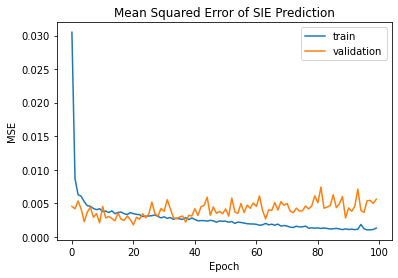

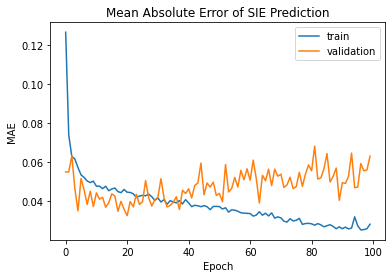

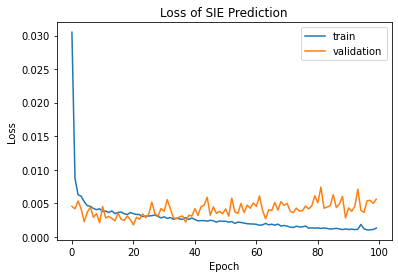

In [25]:
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('Mean Squared Error of SIE Prediction')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Mean Absolute Error of SIE Prediction')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss of SIE Prediction')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from numpy import sqrt

#model.load_weights("weights.best.hdf5")

cols = len(df.columns)
pred = model.predict(X_test)

predicted_dataset = dataset
predicted_dataset[len(predicted_dataset)-len(pred):, cols-1] = pred[:, 0]
scaled_predicted_dataset = scaler.inverse_transform(predicted_dataset)

predicted_df = df.copy()
predicted_df['sea_ice_extent'][len(predicted_dataset)-len(pred):] = scaled_predicted_dataset[len(predicted_dataset)-len(pred):, cols-1]

predictions = pd.DataFrame()
predictions['predicted'] = (predicted_df['sea_ice_extent'][len(predicted_dataset)-len(pred):])
predictions['actual'] = (df['sea_ice_extent'][len(predicted_dataset)-len(pred):])
predictions = predictions.astype(float)

45/45 [==============================] - 1s 3ms/step


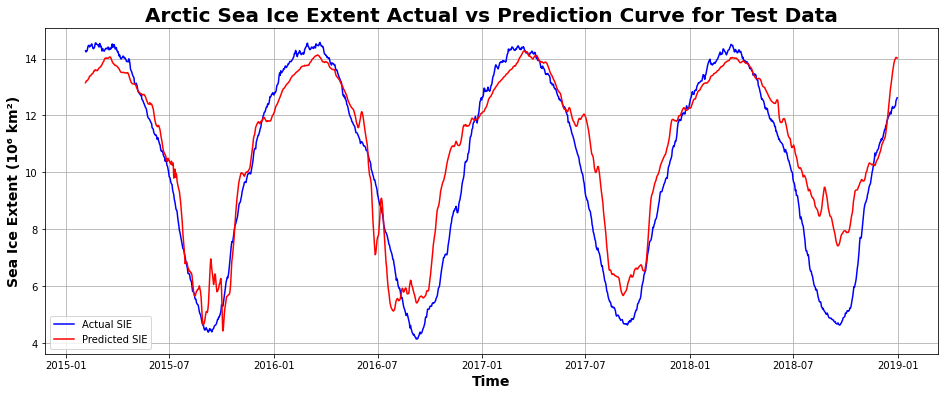

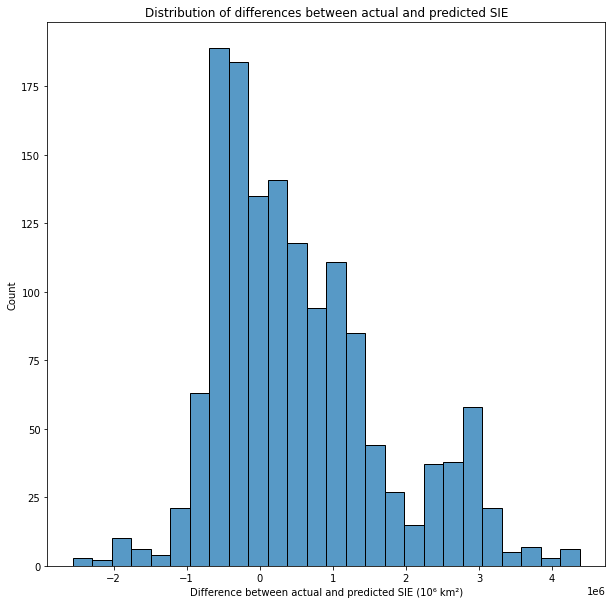

MSE :  1644300877355.4019 (10⁶ km²)
MSPE : 4.335544679980473 %
RMSE :  1282302.958491246 (10⁶ km²)
RMSPE : 20.821970800047897 %
MAE :  933500.7442186405 (10⁶ km²)
MAPE :  10.29374489271814 %
R2 :  0.7843303735432314


In [27]:
plt.figure(figsize = (16,6))
ax = plt.axes()
# ax.set_facecolor('#dcdcdc')

plt.title('Arctic Sea Ice Extent Actual vs Prediction Curve for Test Data', fontsize = 20,fontweight = "bold")
plt.xlabel('Time' , fontsize = 14,fontweight = "bold")
plt.ylabel('Sea Ice Extent (10\u2076 km\u00b2)', fontsize = 14,fontweight = "bold")
plt.plot(predictions['actual']/10**6, 'blue', label='Actual SIE')
plt.plot(predictions['predicted']/10**6, 'red', label='Predicted SIE')
plt.legend()
plt.grid()
plt.show

predictions['diff'] = predictions['predicted'] - predictions['actual']
plt.figure(figsize=(10,10))
plt.xlabel('Difference between actual and predicted SIE (10\u2076 km\u00b2)')
sns.histplot(predictions['diff'])
plt.title('Distribution of differences between actual and predicted SIE')
plt.show()

mspe = (np.mean(np.square((predictions['actual'].values - predictions['predicted'].values) / predictions['actual'].values))) * 100
rmspe = (np.sqrt(np.mean(np.square((predictions['actual'].values - predictions['predicted'].values) / predictions['actual'].values)))) * 100

print("MSE : ", mean_squared_error(predictions['predicted'].values, predictions['actual'].values), "(10\u2076 km\u00b2)")
print("MSPE :", mspe, "%")
print("RMSE : ", sqrt(mean_squared_error(predictions['predicted'].values, predictions['actual'].values)), "(10\u2076 km\u00b2)")
print("RMSPE :", rmspe, "%")
print("MAE : ", mean_absolute_error(predictions['predicted'].values, predictions['actual'].values), "(10\u2076 km\u00b2)")
print("MAPE : ", mean_absolute_percentage_error(predictions['predicted'].values, predictions['actual'].values)*100, "%")
print("R2 : ", r2_score(predictions['predicted'].values, predictions['actual'].values))

In [28]:
# while True:pass